<a href="https://colab.research.google.com/github/alesha-ofc-he/Kassymbekov_Merekeyev_DL_Project/blob/main/Drone_Section_1_Foundations_of_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron Implementation

Block 1: Imports and Data Prep

Loading data from binary files...
Converting to Grayscale (Manual Dot Product)...
Manual One-Hot Encoding...
Train X Shape: (1024, 10000)
Train Y Shape: (10, 10000)


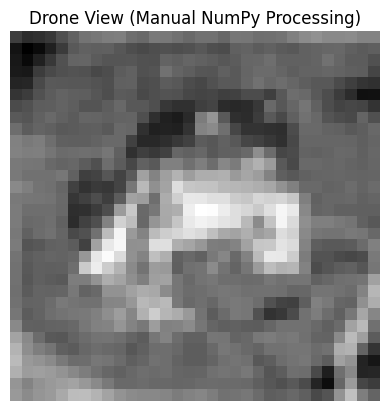

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

#Random seed
np.random.seed(69)

# 1. Download dataset directly
if not os.path.exists('cifar-10-batches-py'):
    print("Downloading CIFAR-10 raw binary...")
    !wget -q https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    !tar -xzf cifar-10-python.tar.gz

# 2. Helper to read binary files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data_numpy_only():
    print("Loading data from binary files...")

    # Load just one batch to save RAM (10,000 images)
    train_batch = unpickle('cifar-10-batches-py/data_batch_1')
    test_batch = unpickle('cifar-10-batches-py/test_batch')

    # Extract raw data
    X_train_raw = train_batch[b'data'] # Shape: (10000, 3072)
    y_train_raw = np.array(train_batch[b'labels'])

    X_test_raw = test_batch[b'data']
    y_test_raw = np.array(test_batch[b'labels'])

    # --- MANUAL PREPROCESSING ---

    print("Converting to Grayscale (Manual Dot Product)...")

    # Step A: Reshape to (N, 3, 32, 32) -> Original format
    # Step B: Transpose to (N, 32, 32, 3) -> Channels Last
    X_train_rgb = X_train_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test_rgb = X_test_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    # Step C: Apply formula Y = 0.299R + 0.587G + 0.114B
    # Now that 3 (channels) is the last dimension, np.dot works perfectly
    weights = np.array([0.299, 0.587, 0.114])
    X_train_gray = np.dot(X_train_rgb, weights)
    X_test_gray = np.dot(X_test_rgb, weights)

    # Step D: Normalize and Flatten
    X_train_flat = (X_train_gray / 255.0).reshape(len(X_train_gray), -1)
    X_test_flat = (X_test_gray / 255.0).reshape(len(X_test_gray), -1)

    print("Manual One-Hot Encoding...")

    def to_one_hot(y, k=10):
        one_hot = np.zeros((len(y), k))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot.T

    Y_train_enc = to_one_hot(y_train_raw)
    Y_test_enc = to_one_hot(y_test_raw)

    # Return Transposed X (Features, Examples)
    return X_train_flat.T, Y_train_enc, X_test_flat.T, Y_test_enc

# Load Data
X_train, Y_train, X_test, Y_test = load_data_numpy_only()

print(f"Train X Shape: {X_train.shape}")
print(f"Train Y Shape: {Y_train.shape}")

# Visualize one image to check Grayscale
plt.imshow(X_train[:, 0].reshape(32, 32), cmap='gray')
plt.title("Drone View (Manual NumPy Processing)")
plt.axis('off')
plt.show()

Block 2: Math Helpers

In [4]:
class Activations:
    # Sigmoid
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_derivative(z):
        s = Activations.sigmoid(z)
        return s * (1 - s)

    # Tanh
    @staticmethod
    def tanh(z):
        return np.tanh(z)

    @staticmethod
    def tanh_derivative(z):
        return 1 - np.power(np.tanh(z), 2)

    # ReLU
    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_derivative(z):
        return (z > 0).astype(float)

    # Softmax
    @staticmethod
    def softmax(z):
        # Subtract max for stability
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

# Loss Function
def compute_loss(Y, A_last, task='classification'):
    m = Y.shape[1]
    if task == 'classification':
        # Cross Entropy
        epsilon = 1e-15
        loss = -np.sum(Y * np.log(A_last + epsilon)) / m
    else:
        # MSE (Mean Squared Error)
        loss = np.sum((A_last - Y) ** 2) / (2 * m)
    return np.squeeze(loss)

Block 3: MLP Class Implementation

In [9]:
class MultiLayerPerceptron:
    def __init__(self, layer_dims, activation_fn='relu', task='classification'):
        self.layer_dims = layer_dims
        self.activation_fn = activation_fn
        self.task = task
        self.parameters = {}
        self.initialize_parameters()

    def initialize_parameters(self):
        L = len(self.layer_dims)
        for l in range(1, L):
            # Scale weights based on activation
            if self.activation_fn == 'relu':
                scale = np.sqrt(2. / self.layer_dims[l-1])
            else:
                scale = np.sqrt(1. / self.layer_dims[l-1])

            self.parameters['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * scale
            self.parameters['b' + str(l)] = np.zeros((self.layer_dims[l], 1))

    def forward_propagation(self, X):
        caches = {}
        A = X
        L = len(self.layer_dims)

        for l in range(1, L - 1):
            Z = np.dot(self.parameters['W' + str(l)], A) + self.parameters['b' + str(l)]
            caches['Z' + str(l)] = Z
            caches['A_prev' + str(l)] = A

            if self.activation_fn == 'sigmoid':
                A = Activations.sigmoid(Z)
            elif self.activation_fn == 'tanh':
                A = Activations.tanh(Z)
            elif self.activation_fn == 'relu':
                A = Activations.relu(Z)
            caches['A' + str(l)] = A

        # Output Layer
        l = L - 1
        Z_last = np.dot(self.parameters['W' + str(l)], A) + self.parameters['b' + str(l)]
        caches['Z' + str(l)] = Z_last
        caches['A_prev' + str(l)] = A

        if self.task == 'classification':
            A_last = Activations.softmax(Z_last)
        else:
            A_last = Z_last # Linear

        caches['A' + str(l)] = A_last
        return A_last, caches

    def backward_propagation(self, A_last, Y, caches):
        grads = {}
        L = len(self.layer_dims)
        m = Y.shape[1]

        # Output Gradient
        dZ = A_last - Y
        grads['dW' + str(L-1)] = (1/m) * np.dot(dZ, caches['A_prev' + str(L-1)].T)
        grads['db' + str(L-1)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        # Hidden Layer Gradients
        for l in reversed(range(1, L - 1)):
            dA = np.dot(self.parameters['W' + str(l+1)].T, dZ)
            Z = caches['Z' + str(l)]

            if self.activation_fn == 'sigmoid':
                dZ = dA * Activations.sigmoid_derivative(Z)
            elif self.activation_fn == 'tanh':
                dZ = dA * Activations.tanh_derivative(Z)
            elif self.activation_fn == 'relu':
                dZ = dA * Activations.relu_derivative(Z)

            grads['dW' + str(l)] = (1/m) * np.dot(dZ, caches['A_prev' + str(l)].T)
            grads['db' + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        return grads

    def update_parameters(self, grads, learning_rate):
        L = len(self.layer_dims)
        for l in range(1, L):
            self.parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
            self.parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    # Added 'print_every' parameter to control console log size
    def fit(self, X, Y, epochs=10, batch_size=64, learning_rate=0.01, print_every=5):
        costs = []
        m = X.shape[1]

        for i in range(epochs):
            # Shuffle
            permutation = np.random.permutation(m)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]

            # Mini-batches
            for j in range(0, m, batch_size):
                begin, end = j, j + batch_size
                X_batch = X_shuffled[:, begin:end]
                Y_batch = Y_shuffled[:, begin:end]

                A_last, caches = self.forward_propagation(X_batch)
                grads = self.backward_propagation(A_last, Y_batch, caches)
                self.update_parameters(grads, learning_rate)

            # Record Cost
            A_full, _ = self.forward_propagation(X)
            cost = compute_loss(Y, A_full, self.task)
            costs.append(cost)

            # Only print if 'i' matches 'print_every' interval
            if i % print_every == 0:
                print(f"Epoch {i}: Loss {cost:.4f}")

        return costs

    def predict(self, X):
        A_last, _ = self.forward_propagation(X)
        if self.task == 'classification':
            return np.argmax(A_last, axis=0)
        return A_last

Block 4: Activation Comparison & Histograms

--- Activation Comparison ---

Training with sigmoid...
Epoch 0: Loss 2.2993
Epoch 5: Loss 2.2754
Epoch 10: Loss 2.2274
Epoch 15: Loss 2.1830
Accuracy: 19.07%

Training with tanh...
Epoch 0: Loss 2.1926
Epoch 5: Loss 2.1205
Epoch 10: Loss 2.0857
Epoch 15: Loss 2.1426
Accuracy: 24.14%

Training with relu...
Epoch 0: Loss 2.2944
Epoch 5: Loss 2.1138
Epoch 10: Loss 1.9962
Epoch 15: Loss 2.4733
Accuracy: 29.26%


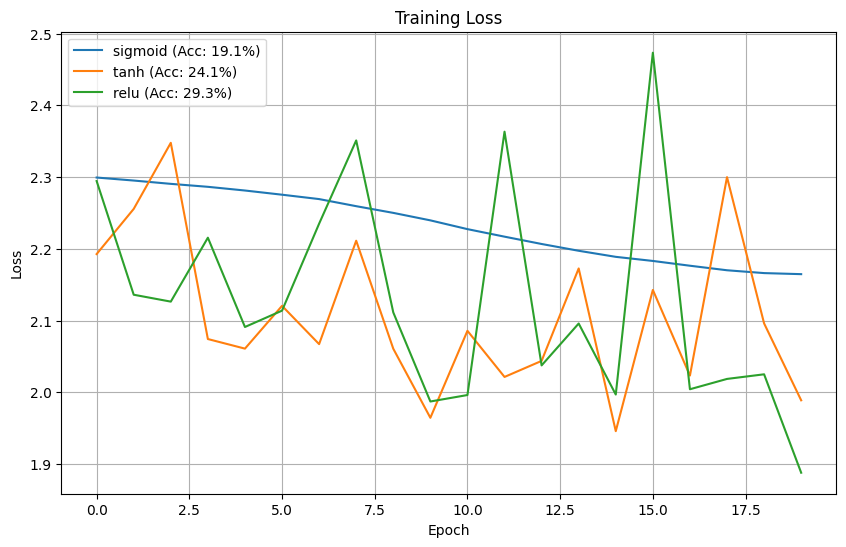

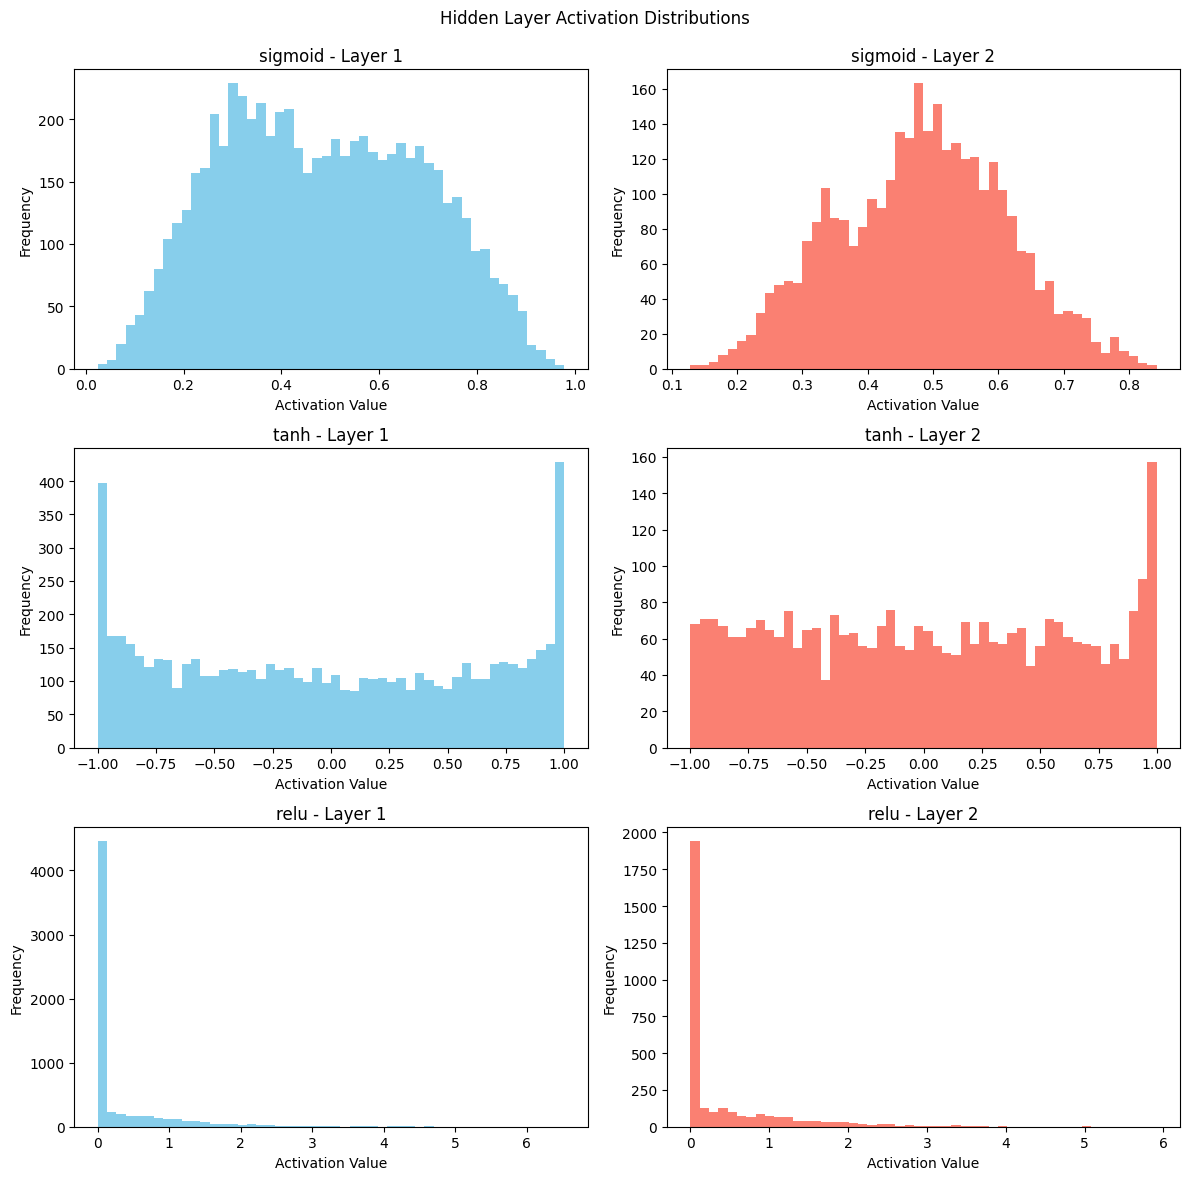

In [11]:
# Settings
layers = [1024, 64, 32, 10]
epochs = 20
lr = 0.05
batch_size = 128

results = {}
funcs = ['sigmoid', 'tanh', 'relu']

print("--- Activation Comparison ---")

for name in funcs:
    print(f"\nTraining with {name}...")
    # Train
    mlp = MultiLayerPerceptron(layers, activation_fn=name)
    # Using print_every=5 for short training
    costs = mlp.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, learning_rate=lr, print_every=5)

    # Test
    preds = mlp.predict(X_test)
    true_labels = np.argmax(Y_test, axis=0)
    acc = np.mean(preds == true_labels) * 100

    results[name] = {'costs': costs, 'model': mlp, 'acc': acc}
    print(f"Accuracy: {acc:.2f}%")

# Plot 1: Learning Curves
plt.figure(figsize=(10, 6))
for name in results:
    plt.plot(results[name]['costs'], label=f"{name} (Acc: {results[name]['acc']:.1f}%)")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Activation Histograms (Course Requirement)
def plot_histograms(models_dict, X_sample):
    fig, axes = plt.subplots(len(models_dict), 2, figsize=(12, 12)) # Increased height slightly
    fig.suptitle("Hidden Layer Activation Distributions")

    for i, (name, res) in enumerate(models_dict.items()):
        _, caches = res['model'].forward_propagation(X_sample)

        # Layer 1
        ax1 = axes[i, 0]
        ax1.hist(caches['A1'].flatten(), bins=50, color='skyblue')
        ax1.set_title(f"{name} - Layer 1")
        ax1.set_xlabel("Activation Value") # Added Label
        ax1.set_ylabel("Frequency")        # Added Label

        # Layer 2
        ax2 = axes[i, 1]
        ax2.hist(caches['A2'].flatten(), bins=50, color='salmon')
        ax2.set_title(f"{name} - Layer 2")
        ax2.set_xlabel("Activation Value") # Added Label
        ax2.set_ylabel("Frequency")        # Added Label

    plt.tight_layout()
    plt.subplots_adjust(top=0.93) # Make room for suptitle
    plt.show()

# Show histograms on sample data
plot_histograms(results, X_test[:, :100])

Block 5: Universal Approximation (Sine Wave)


--- Sine Wave Regression ---
Training...
Epoch 0: Loss 0.2051
Epoch 500: Loss 0.0176
Epoch 1000: Loss 0.0152
Epoch 1500: Loss 0.0133
Epoch 2000: Loss 0.0117
Epoch 2500: Loss 0.0103
Epoch 3000: Loss 0.0091
Epoch 3500: Loss 0.0080
Epoch 4000: Loss 0.0071
Epoch 4500: Loss 0.0063


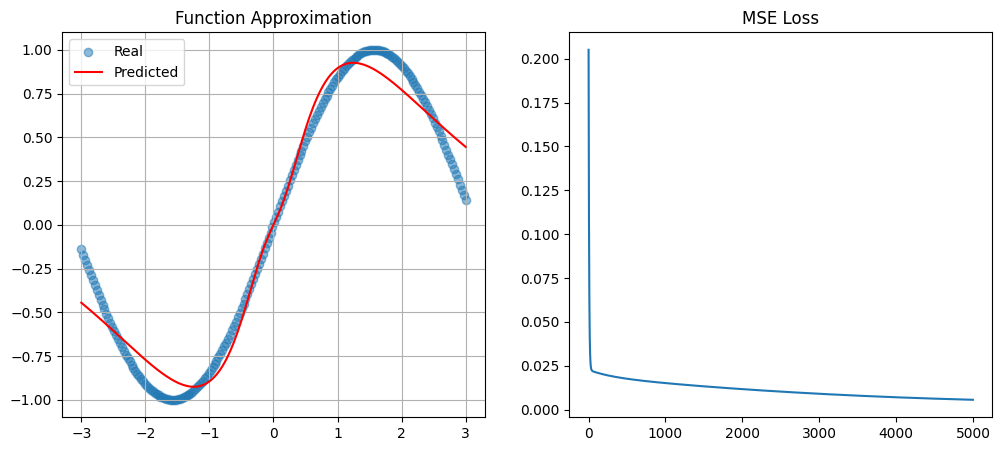

In [12]:
print("\n--- Sine Wave Regression ---")

# Data: y = sin(x)
X_sine = np.linspace(-3, 3, 200).reshape(1, -1)
Y_sine = np.sin(X_sine)

# Regression MLP (Tanh is best for curves)
sine_net = MultiLayerPerceptron(
    layer_dims=[1, 20, 20, 1],
    activation_fn='tanh',
    task='regression'
)

# Train
print("Training...")
# Using print_every=500 to reduce console spam (5000 epochs -> 10 lines)
loss_history = sine_net.fit(X_sine, Y_sine, epochs=5000, batch_size=200, learning_rate=0.01, print_every=500)

# Predict
Y_pred = sine_net.predict(X_sine)

# Visualize
plt.figure(figsize=(12, 5))

# Fit
plt.subplot(1, 2, 1)
plt.scatter(X_sine.flatten(), Y_sine.flatten(), alpha=0.5, label='Real')
plt.plot(X_sine.flatten(), Y_pred.flatten(), color='red', label='Predicted')
plt.title("Function Approximation")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title("MSE Loss")

plt.show()

# New section